# Two task network 

## Network has some inputs

1. The fixation. 
1. The first context mod. 
1. The second ontext mod. 

## Network has five outputs
1. The fixation. 
1. The first output.
1. The second output




<div>
<img src="./images/Sheme.png" width="300"/>
</div>

> Learning rule: superspike

> Neuron type: LifAdex + refrac

> Task: romo


In [4]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt  # for analys
from cgtasknet.net.lifadexrefrac import SNNlifadexrefrac
from cgtasknet.tasks.reduce import (
    MultyReduceTasks,
    RomoTaskRandomModParameters,
    RomoTaskParameters,
    DMTaskParameters,
    DMTaskRandomModParameters,
)
from norse.torch.functional.lif_adex_refrac import LIFAdExRefracParameters
from norse.torch.functional.lif_adex import LIFAdExParameters

# from norse.torch import LIF

## Step -1: Create dataset

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
print(f'Device: {("gpu (cuda)" if device.type=="cuda" else "cpu")}')

Device: gpu (cuda)


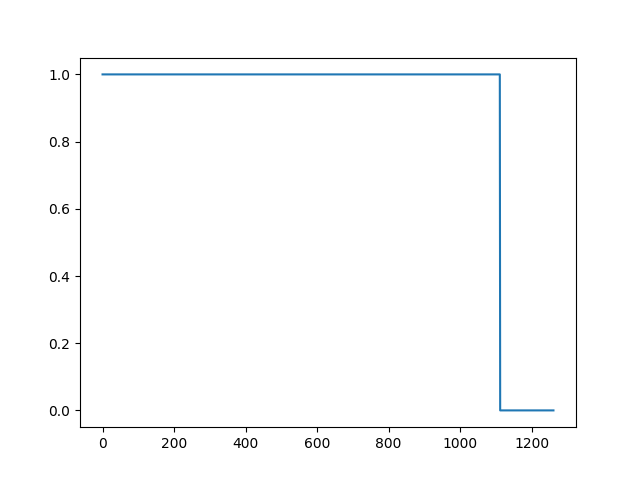

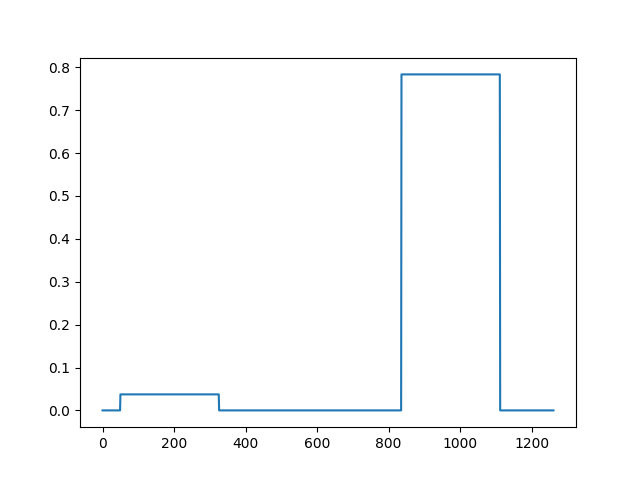

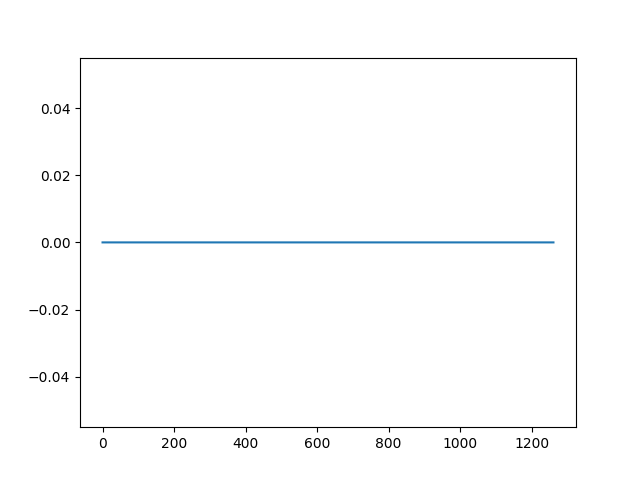

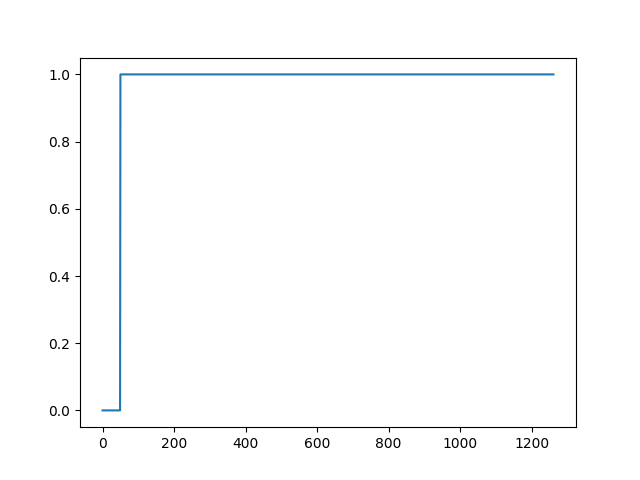

In [7]:
%matplotlib widget
batch_size = 50
number_of_tasks = 1
romo_parameters = RomoTaskRandomModParameters(
    romo=RomoTaskParameters(
        delay=0.1,
        positive_shift_delay_time=0.5,
        trial_time=0.1,
        positive_shift_trial_time=0.2,
    ),
    n_mods=1,
)
dm_parameters = DMTaskRandomModParameters(
    dm=DMTaskParameters(trial_time=0.1, positive_shift_trial_time=0.8), n_mods=1
)

task_names = ["RomoTask1", "DMTask1"]
tasks = dict()
tasks[task_names[0]] = romo_parameters
tasks[task_names[1]] = dm_parameters
# task_parameters = RomoTaskParameters(delay=0.1, positive_shift_delay_time=.0, trial_time = 0.2, positive_shift_trial_time=.0)
Task = MultyReduceTasks(
    tasks=tasks,
    batch_size=batch_size,
    enable_fixation_delay=True,
    sequence_bathces=True,
    number_of_inputs=1,
)


demonstrate_in, demonstrate_out = Task.dataset(1, delay_between=0)
for i in range(4):
    plt.figure()
    plt.plot(demonstrate_in[:, 0, i])

    plt.show()
    plt.close()

In [8]:
tau_ada_inv_distrib = np.load("tau_ada_inv.npy")

## Step 1.1: Create model

In [9]:
feature_size, output_size = Task.feature_and_act_size
hidden_size = 450

neuron_parameters = LIFAdExRefracParameters(
    LIFAdExParameters(
        v_th=torch.as_tensor(0.65),
        tau_ada_inv=torch.from_numpy(tau_ada_inv_distrib),
        alpha=30,
        # method='heavi_erfc',
        method="super",
    ),
    rho_reset=torch.as_tensor(1),
    # rho_reset = torch.as_tensor(5)
)
model = SNNlifadexrefrac(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=500,
)
# model = torch.nn.DataParallel(model, device_ids=[0]).to(device)

In [20]:
tau_ada_inv_distrib = neuron_parameters.lif_adex.tau_ada_inv.cpu().numpy()

In [22]:
# np.save('tau_ada_inv', tau_ada_inv_distrib)

## Step 1.2: Save pre-learning weights

In [6]:
weights_pre_l = []
with torch.no_grad():
    for name, param in model.named_parameters():
        print(f"name = {name}")
        if param.requires_grad:
            weights_pre_l.append((param).cpu().numpy())

name = adexrefrac.input_weights
name = adexrefrac.recurrent_weights
name = exp_f.linear.weight
name = exp_f.linear.bias


## Step 2: loss and creterion 

In [7]:
learning_rate = 1e-3


class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [10]:
name = f"Train_dm_and_romo_task_reduce_lif_adex_random_delay_long_a{hidden_size}"

#Precreate data

In [9]:
l_inputs = []
l_outputs = []
from tqdm import tqdm

for i in tqdm(range(2000)):
    tmp_inputs, tmp_target_outputs = Task.dataset(number_of_tasks, delay_between=0)
    tmp_inputs += np.random.normal(0, 0.01, size=tmp_inputs.shape)
    l_inputs.append(tmp_inputs)
    l_outputs.append(tmp_target_outputs)

100%|██████████| 2000/2000 [00:20<00:00, 97.90it/s] 


## Step 3: Train loop

In [10]:
from cgtasknet.net.states import LIFAdExRefracInitState
from cgtasknet.instruments.instrument_accuracy_network import correct_answer

init_state = LIFAdExRefracInitState(batch_size, hidden_size, device=device)

#

running_loss = 0
from tqdm import tqdm

for i in tqdm(range(2000)):
    inputs = torch.from_numpy(l_inputs[i]).type(torch.float).to(device)
    target_outputs = torch.from_numpy(l_outputs[i]).type(torch.float).to(device)
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, _ = model(inputs)

    loss = criterion(outputs, target_outputs)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 10 == 9:
        with open("log_multy.txt", "a") as f:
            f.write("epoch: {:d} loss: {:0.5f}\n".format(i + 1, running_loss / 10))
        running_loss = 0.0
        with torch.no_grad():
            torch.save(
                model.state_dict(),
                name,
            )
    if i % 10 == 9:

        result = 0
        for j in range(10):
            inputs, target_outputs = Task.dataset(1, delay_between=0)
            inputs += np.random.normal(0, 0.01, size=(inputs.shape))
            inputs = torch.from_numpy(inputs).type(torch.float).to(device)
            target_outputs = (
                torch.from_numpy(target_outputs).type(torch.float).to(device)
            )
            outputs = model(inputs)[0]
            answers = correct_answer(
                outputs[:, :, 1:], target_outputs[:, :, 1:], target_outputs[:, :, 0]
            )
            result += torch.sum(answers).item()
        accuracy = result / batch_size / 10 * 100
        with open("accuracy_multy.txt", "a") as f:
            f.write(f"ecpoch = {i}; correct/all = {accuracy}\n")
print("Finished Training")

100%|██████████| 2000/2000 [2:53:10<00:00,  5.20s/it]  

Finished Training


In [11]:
inputs = torch.from_numpy(l_inputs[i]).type(torch.float).to(device)

In [12]:
model = model.to(device)

In [17]:
from cgtasknet.net.states import LIFAdExRefracInitState
from cgtasknet.instruments.instrument_accuracy_network import correct_answer
from tqdm import tqdm

task_parameters_test = RomoTaskParameters(
    delay=0.5,
    positive_shift_delay_time=0,
    trial_time=0.1,
    positive_shift_trial_time=0.2,
)
result = 0
model = model.to(torch.device("cpu"))
for i in tqdm(range(100)):
    inputs, target_outputs = Task.dataset(1, delay_between=0)
    inputs += np.random.normal(0, 0.01, size=inputs.shape)
    inputs = torch.from_numpy(inputs).type(torch.float)
    target_outputs = torch.from_numpy(target_outputs).type(torch.float)
    outputs = model(inputs)[0]
    answers = correct_answer(
        outputs[:, :, 1:], target_outputs[:, :, 1:], target_outputs[:, :, 0]
    )
    result += torch.sum(answers).item()
round(result / batch_size / 100 * 100, 2)

100%|██████████| 100/100 [04:02<00:00,  2.43s/it]


96.5

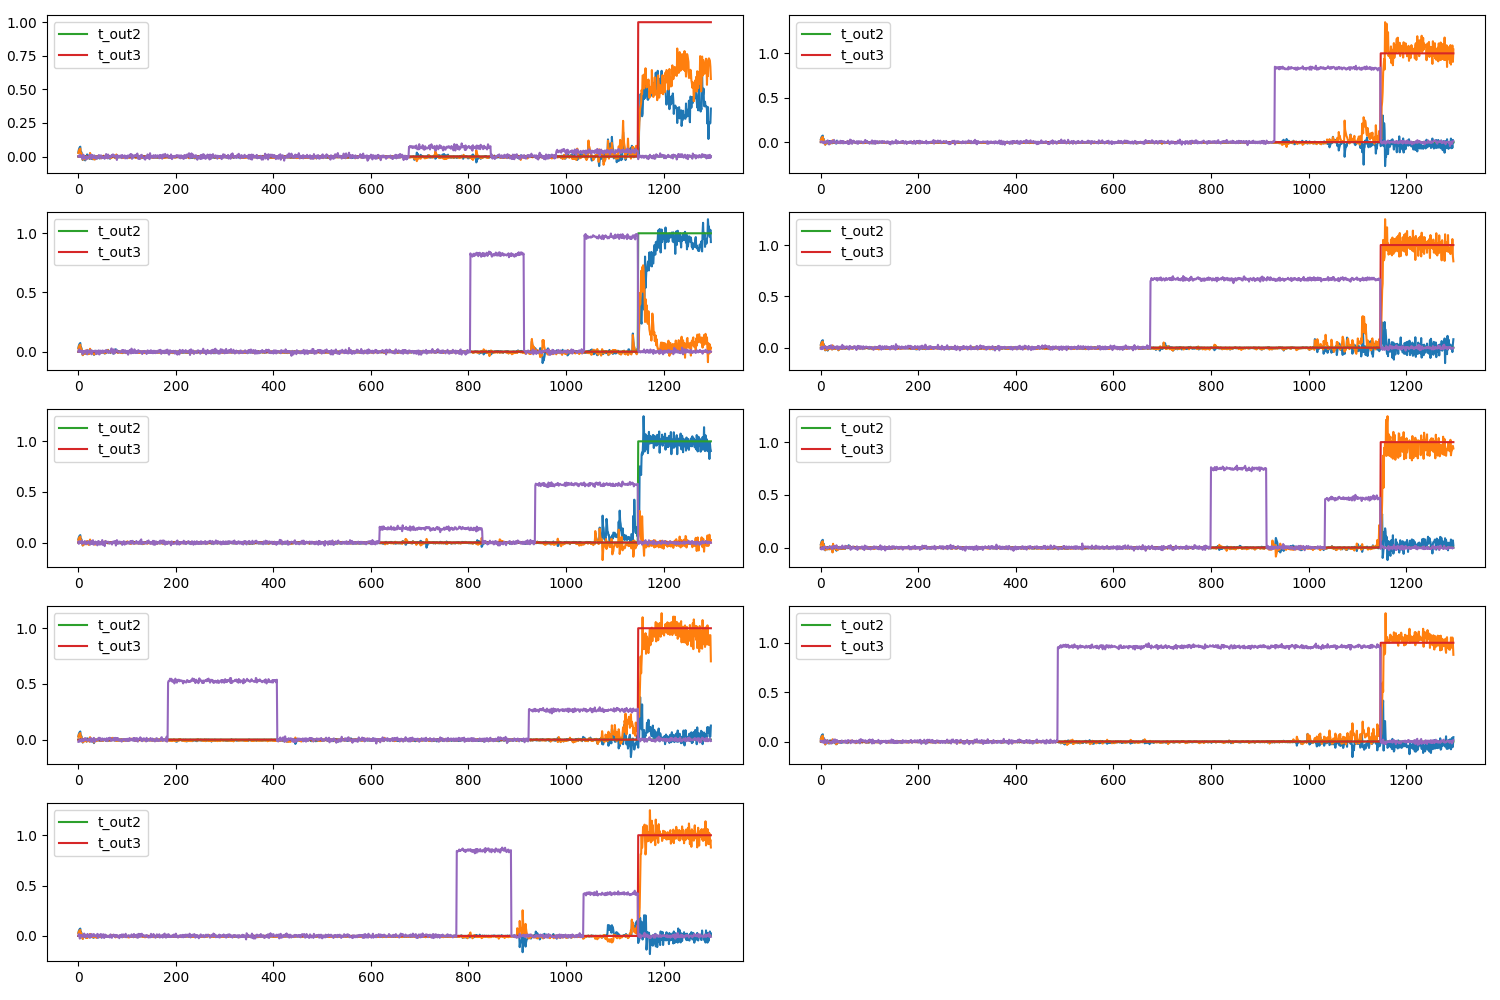

In [20]:
fig = plt.figure(figsize=(15, 10))


start = 15
for batch in range(start, 9 + start, 1):
    fig.add_subplot(520 + batch + 1 - start)
    plt.plot(outputs[:, batch, 1].detach().cpu())
    plt.plot(outputs[:, batch, 2].detach().cpu())
    plt.plot(target_outputs.detach().cpu()[:, batch, 1], label=f"t_out{2}")
    plt.plot(target_outputs.detach().cpu()[:, batch, 2], label=f"t_out{3}")
    plt.plot(inputs[:, batch, 1].detach().cpu())
    plt.legend()
    # plt.plot(inputs[:, 0, 0].detach().cpu())
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
fig = plt.figure(figsize=(15, 10))

start = 30
for batch in range(start, 9 + start, 1):
    fig.add_subplot(520 + batch + 1 - start)
    plt.plot(inputs[:, batch, 0].detach().cpu())
    plt.plot(inputs[:, batch, 1].detach().cpu())

    # plt.legend()
    # plt.plot(inputs[:, 0, 0].detach().cpu())
plt.tight_layout()
plt.show()
# plt.close()

In [ ]:
plt.figure()
plt.plot(inputs[:, batch, 1].detach().cpu())

plt.plot(target_outputs.detach().cpu()[:, batch, 1])
plt.plot(target_outputs.detach().cpu()[:, batch, 2])

In [ ]:
# torch.save(model.state_dict(), name)

In [12]:
if True:
    model.load_state_dict(torch.load(name))

In [ ]:
dmparamsv = dmparams1
Taskplot = RomoTask(params=dmparamsv, batch_size=1, delay_beetween=100)
inputs, target_outputs = Taskplot.dataset(10)
inputs += np.random.normal(0, 0.01, size=(inputs.shape))
inputs = torch.from_numpy(inputs).type(torch.float).to(device)
target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)
outputs, states = model(inputs)

In [ ]:
%matplotlib inline
for i in range(inputs.shape[2]):
    plt.plot(inputs[:, 0, i].detach().cpu().numpy(), label=fr"$u_{i + 1}$")
    plt.legend()
    plt.show()
    plt.close()
for i in range(outputs.shape[2]):
    plt.plot(outputs[:, 0, i].detach().cpu().numpy(), label=fr"$u_{i + 1}$")
    plt.plot(
        target_outputs[:, 0, i].detach().cpu().numpy(), label=fr"$u^{{target}}_{i + 1}$"
    )
    plt.legend()
    plt.show()
    plt.close()

plt.plot(
    outputs[:, 0, -2].detach().cpu().numpy() - outputs[:, 0, -1].detach().cpu().numpy(),
    label=fr"$u_2 - u_3$",
)
plt.plot(target_outputs[:, 0, -2].detach().cpu().numpy(), label=fr"$u^{{target}}_{2}$")
plt.plot(target_outputs[:, 0, -1].detach().cpu().numpy(), label=fr"$u^{{target}}_{3}$")
plt.legend()
plt.show()
plt.close()

In [ ]:
%matplotlib inline
for i in range(inputs.shape[2]):
    plt.plot(inputs[:, 0, i].detach().cpu().numpy(), label=fr"$u_{i + 1}$")

plt.legend()
plt.show()
plt.close()
plt.plot(target_outputs[:, 0, 1].detach().cpu().numpy(), label=fr"$y_{2}$")
plt.plot(target_outputs[:, 0, 2].detach().cpu().numpy(), label=fr"$y_{3}$")

In [ ]:
weights_post_l = []
with torch.no_grad():
    for name, param in model.named_parameters():
        if param.requires_grad:
            weights_post_l.append((param).cpu().numpy())

In [ ]:
%matplotlib inline
for i in range(len(weights_pre_l) - 1):
    plt.imshow((weights_pre_l[i]), aspect="auto", cmap="jet")
    plt.colorbar()
    plt.show()

In [ ]:
%matplotlib inline
for i in range(len(weights_pre_l) - 1):
    plt.imshow(
        (weights_post_l[i]),
        aspect="auto",
        cmap="jet",
    )
    plt.colorbar()
    plt.show()

In [ ]:
%matplotlib inline
for i in range(len(weights_pre_l) - 1):
    plt.imshow(
        (weights_post_l[i] - weights_pre_l[i]),
        aspect="auto",
        cmap="jet",
        vmin=-0.2,
        vmax=0.4,
    )
    plt.colorbar()
    plt.show()